# We will study the algorithm on the synthetic data

In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
from sklearn.metrics.pairwise import cosine_similarity

# Load the synthetic data

In [17]:
synthetic_data = pd.read_csv('synthetic_ratings_community.csv')

In [18]:
synthetic_data.head()


,Unnamed: 0,UserID,MovieID,rating,binary_rating,true_prob,community_id
0,0,0,0,1,0,1.649040e-46,3
1,1,0,1,1,0,6.648900e-42,3
2,2,0,2,1,0,1.014036e-18,3
3,3,0,3,1,0,9.033729e-28,3
4,4,0,4,1,0,9.025160e-12,3


In [14]:

class EpsilonGreedyRecommender:
    def __init__(self, df, epsilon=1.0,  decay_type='decay_optimal'):
        """
        df: DataFrame with columns ['user_id','MovieID','rating']
        epsilon: initial exploration rate
        decay: if True, apply decay schedule epsilon ~ t^(-1/3)
        """
        self.df = df
        self.movie_ids = df['MovieID'].unique().tolist()
        self.K = len(self.movie_ids)

        self.epsilon_0 = epsilon
        self.epsilon = epsilon
        self.t = 0
        self.decay_type = decay_type

        # Estimated mean rewards (ratings)
        self.q_values = {m_id: 0.0 for m_id in self.movie_ids}
        self.attempts = {m_id: 0 for m_id in self.movie_ids}

        # Prepare a dictionary of ratings per movie
        self.ratings_dict = df.groupby('MovieID')['rating'].apply(list).to_dict()

        # For regret tracking
        self.optimal_mean = df.groupby('MovieID')['rating'].mean().max()
        self.regret_list = []

    def select_movie(self):
        """Epsilon-greedy selection"""
        if random.random() < self.epsilon:
            return random.choice(self.movie_ids)
        else:
            return max(self.q_values, key=self.q_values.get)

    def get_reward(self, movie_id):
        """Sample a rating from the movie's list"""
        return random.choice(self.ratings_dict[movie_id])

    def update_scores(self, movie_id, reward):
        """Incremental update of estimated mean rating"""
        self.attempts[movie_id] += 1
        n = self.attempts[movie_id]
        old_q = self.q_values[movie_id]
        self.q_values[movie_id] = old_q + (reward - old_q) / n

    def step(self):
        """Perform one iteration of epsilon-greedy"""
        self.t += 1
        if self.decay_type == 'decay_fast':
            self.epsilon = self.epsilon_0 / self.t
        elif self.decay_type == 'decay_optimal':
            self.epsilon = self.epsilon_0 * self.t ** (-1/3)
        else :
            self.epsilon = self.epsilon_0

        movie = self.select_movie()
        reward = self.get_reward(movie)
        self.update_scores(movie, reward)

        # Update regret
        instant_regret = self.optimal_mean - reward
        if self.regret_list:
            self.regret_list.append(self.regret_list[-1] + instant_regret)
        else:
            self.regret_list.append(instant_regret)

        return movie, reward






Running strategy: Constant epsilon
Constant epsilon - Run 10/30 completed
Constant epsilon - Run 20/30 completed
Constant epsilon - Run 30/30 completed
Running strategy: 1/t (fast decay)
1/t (fast decay) - Run 10/30 completed
1/t (fast decay) - Run 20/30 completed
1/t (fast decay) - Run 30/30 completed
Running strategy: 1/t^(1/3) (optimal decay)
1/t^(1/3) (optimal decay) - Run 10/30 completed
1/t^(1/3) (optimal decay) - Run 20/30 completed
1/t^(1/3) (optimal decay) - Run 30/30 completed


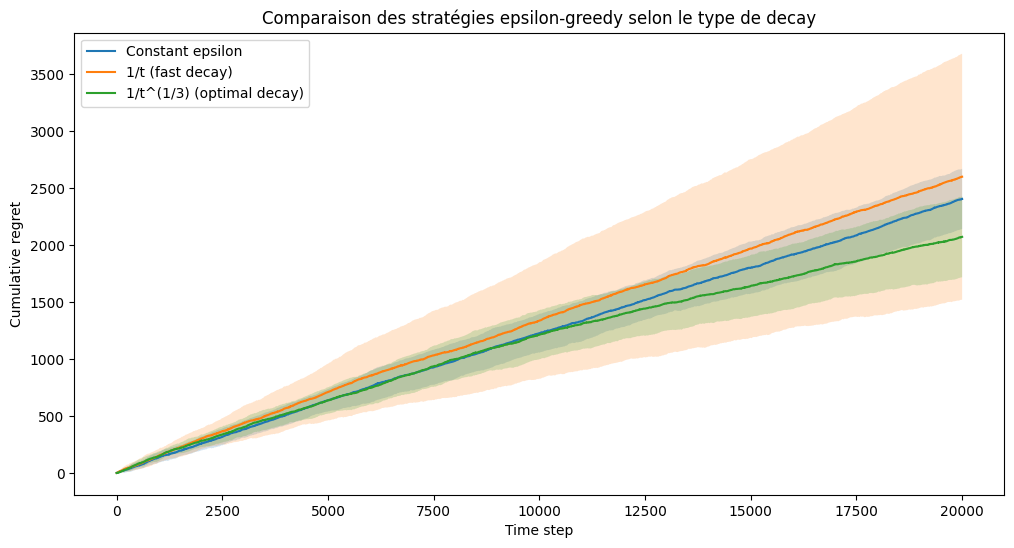

In [ ]:
# parameters
N_RUNS = 30
T = 200000

# Differents decay strategies
decay_types = {
    "Constant epsilon": None,          # constant
    "1/t (fast decay)": "decay_fast",  # epsilon ~ 1/t
    "1/t^(1/3) (optimal decay)": "decay_optimal"  # epsilon ~ 1/t^(1/3)
}

all_mean_regrets = {}

for name, decay_type in decay_types.items():
    print(f"Running strategy: {name}")
    all_regrets = np.zeros((N_RUNS, T))
    
    for i in range(N_RUNS):
        recommender = EpsilonGreedyRecommender(
            df=synthetic_data,
            epsilon=1.0 if decay_type else 0.1,  # small constant if no decay
            decay_type=decay_type
        )
        
        for t in range(T):
            recommender.step()
        
        all_regrets[i] = recommender.regret_list
        
        if (i + 1) % 10 == 0:
            print(f"{name} - Run {i+1}/{N_RUNS} completed")
    
    mean_regret = all_regrets.mean(axis=0)
    std_regret = all_regrets.std(axis=0)
    all_mean_regrets[name] = (mean_regret, std_regret)

# Plotting results
plt.figure(figsize=(12,6))
for name, (mean_regret, std_regret) in all_mean_regrets.items():
    plt.plot(mean_regret, label=name)
    plt.fill_between(
        range(T),
        mean_regret - std_regret,
        mean_regret + std_regret,
        alpha=0.2
    )

plt.xlabel("Time step")
plt.ylabel("Cumulative regret")
plt.title("Comparison of Epsilon-Greedy Decay Strategies")
plt.legend()
plt.show()


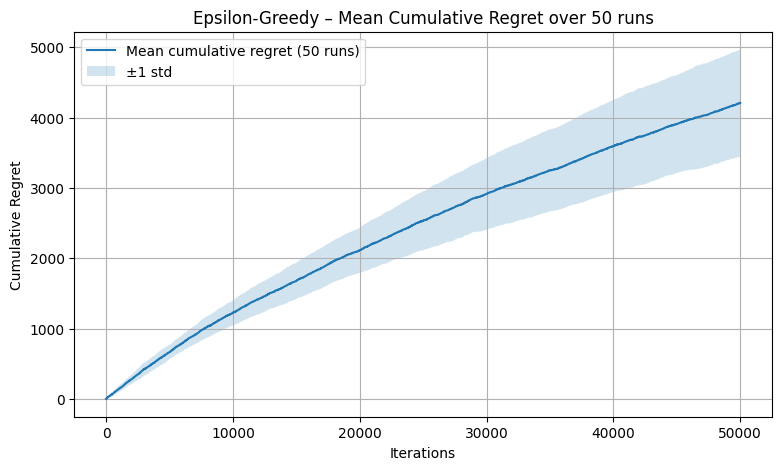

In [9]:
plt.figure(figsize=(9,5))
plt.plot(mean_regret, label="Mean cumulative regret (50 runs)")
plt.fill_between(
    np.arange(T),
    mean_regret - std_regret,
    mean_regret + std_regret,
    alpha=0.2,
    label="Confidence interval"
)

plt.xlabel("Iterations")
plt.ylabel("Cumulative Regret")
plt.title("Epsilon-Greedy : Mean Cumulative Regret over 50 runs")
plt.legend()
plt.grid(True)
plt.show()


# what if we use context?

In [19]:
# We want to see how much communitys have the same tastes for films
community_movie_matrix = (
    synthetic_data
    .groupby(["community_id", "MovieID"])["rating"]
    .mean()
    .unstack(fill_value=0)
)

# Compute cosine similarity between communities


similarity_matrix = cosine_similarity(community_movie_matrix)

similarity_df = pd.DataFrame(
    similarity_matrix,
    index=community_movie_matrix.index,
    columns=community_movie_matrix.index
)

print(similarity_df)

community_id         0         1         2         3         4
community_id                                                  
0             1.000000  0.701459  0.819191  0.733326  0.799457
1             0.701459  1.000000  0.704321  0.802370  0.621899
2             0.819191  0.704321  1.000000  0.702023  0.656110
3             0.733326  0.802370  0.702023  1.000000  0.718242
4             0.799457  0.621899  0.656110  0.718242  1.000000


In [20]:

class EpsilonGreedyRecommenderCommunity:
    def __init__(self, df, epsilon=1.0, decay_type='decay_optimal'):
        """
        df: DataFrame with columns ['UserID','MovieID','rating','community_id']
        """
        self.df = df
        self.movie_ids = df['MovieID'].unique().tolist()
        self.users = df['UserID'].unique().tolist()
        self.communities = df['community_id'].unique().tolist()

        self.epsilon_0 = epsilon
        self.epsilon = epsilon
        self.decay_type = decay_type
        self.t = 0

        # Q-values estimés (espérance globale, bandit classique)
        self.q_values = {m: 0.0 for m in self.movie_ids}
        self.attempts = {m: 0 for m in self.movie_ids}

        # Pré-calcul des moyennes par (communauté, film)
        self.mean_reward_comm = (
            df.groupby(['community_id', 'MovieID'])['rating']
            .mean()
            .to_dict()
        )

        # mu* par communauté = max des moyennes par film
        self.mu_star = {}
        for c in self.communities:
            means_c = [
                v for (comm, _), v in self.mean_reward_comm.items()
                if comm == c
            ]
            self.mu_star[c] = max(means_c)

        # Regrets cumulés
        self.global_regret = []
        self.regret_per_comm = {c: [] for c in self.communities}

    def select_movie(self):
        """Epsilon-greedy"""
        if random.random() < self.epsilon:
            return random.choice(self.movie_ids)
        return max(self.q_values, key=self.q_values.get)

    def update_scores(self, movie_id, reward):
        """Mise à jour incrémentale"""
        self.attempts[movie_id] += 1
        n = self.attempts[movie_id]
        self.q_values[movie_id] += (reward - self.q_values[movie_id]) / n

    def step(self):
        """
        film epsilon-greedy
        utilisateur aléatoire
        communauté
        reward = espérance conditionnelle
        regret instantané basé sur μ*
        """
        self.t += 1

        # Decay epsilon
        if self.decay_type == 'decay_fast':
            self.epsilon = self.epsilon_0 / self.t
        elif self.decay_type == 'decay_optimal':
            self.epsilon = self.epsilon_0 * self.t ** (-1/3)
        else:
            self.epsilon = self.epsilon_0

        # Tirages
        movie = self.select_movie()
        user = random.choice(self.users)

        # Communauté de l'utilisateur
        user_comm = self.df.loc[
            self.df['UserID'] == user, 'community_id'
        ].iloc[0]

        # Espérance du reward pour ce film dans cette communauté
        reward = self.mean_reward_comm.get(
            (user_comm, movie), 0.0
        )

        # Mise à jour bandit
        self.update_scores(movie, reward)

        # Regret instantané
        instant_regret = self.mu_star[user_comm] - reward

        # Cumul par communauté
        if self.regret_per_comm[user_comm]:
            self.regret_per_comm[user_comm].append(
                self.regret_per_comm[user_comm][-1] + instant_regret
            )
        else:
            self.regret_per_comm[user_comm].append(instant_regret)

        # Cumul global
        if self.global_regret:
            self.global_regret.append(self.global_regret[-1] + instant_regret)
        else:
            self.global_regret.append(instant_regret)

        return movie, user, user_comm, reward, instant_regret


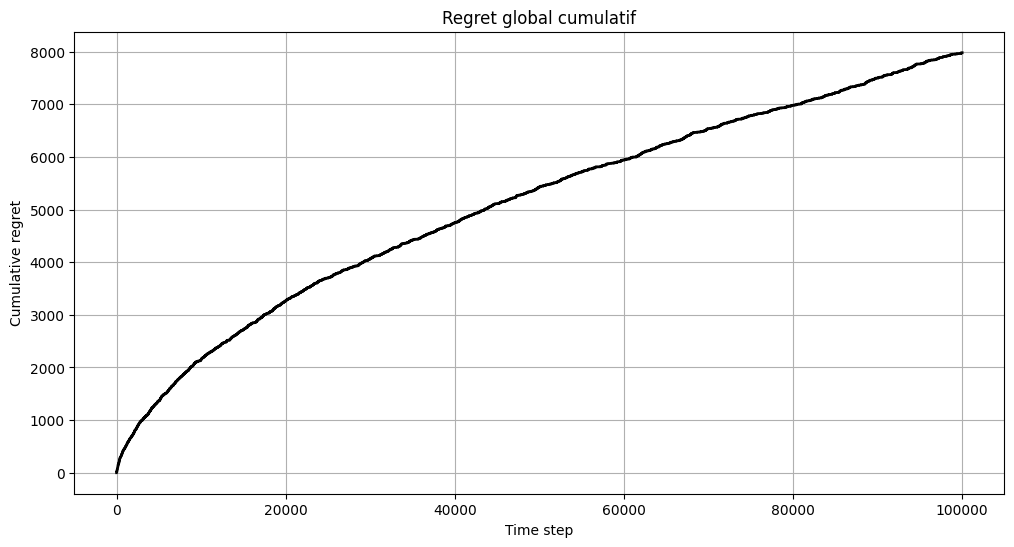

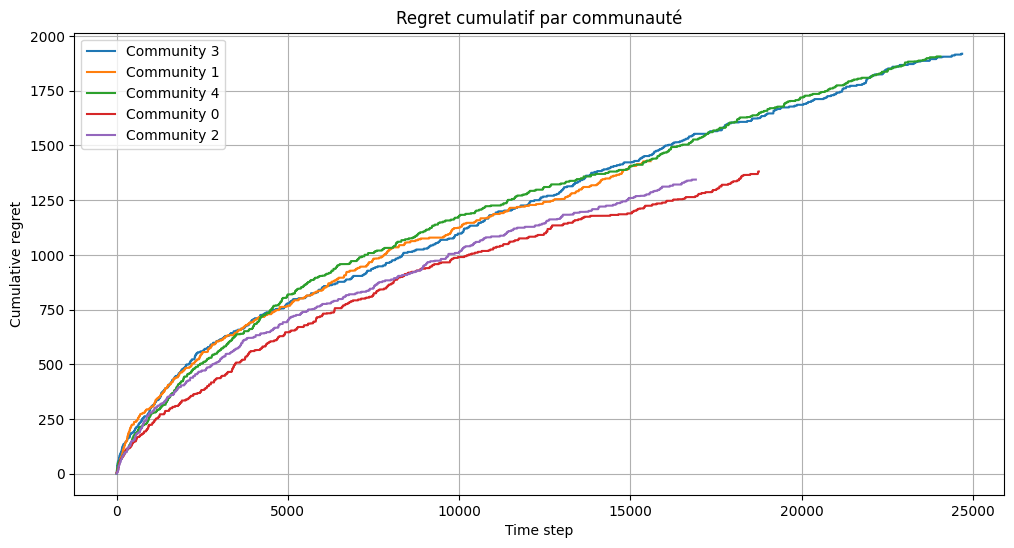

In [ ]:
## Paramètres de simulation
N_STEPS = 100000

# Instanciation du recommender
recommender = EpsilonGreedyRecommenderCommunity(
    df=synthetic_data,
    epsilon=1.0,
    decay_type='decay_optimal'
)

# Simulation
for t in range(N_STEPS):
    recommender.step()  # plus besoin de passer user_id, la méthode tire un utilisateur aléatoire

# Tracé du regret global cumulatif
plt.figure(figsize=(12,6))
plt.plot(recommender.global_regret, color='black', linewidth=2)
plt.xlabel("Time step")
plt.ylabel("Cumulative regret")
plt.title("Regret global cumulatif")
plt.grid(True)
plt.show()

# Tracé du regret cumulatif par communauté
plt.figure(figsize=(12,6))
for comm_id, regrets in recommender.regret_per_comm.items():
    plt.plot(regrets, label=f"Community {comm_id}")
plt.xlabel("Time step")
plt.ylabel("Cumulative regret")
plt.title("Regret cumulatif par communauté")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import random

class EpsilonGreedyRecommender:
    def __init__(self, df, epsilon=1.0, decay_type='decay_optimal'):
        """
        df: DataFrame with columns ['user_id','MovieID','rating']
        epsilon: initial exploration rate
        decay_type: 'decay_fast', 'decay_optimal' or None
        """
        self.df = df
        self.movie_ids = df['MovieID'].unique().tolist()
        self.K = len(self.movie_ids)

        self.epsilon_0 = epsilon
        self.epsilon = epsilon
        self.t = 0
        self.decay_type = decay_type

        # Estimated mean rewards (Q-values)
        self.q_values = {m_id: 0.0 for m_id in self.movie_ids}
        self.attempts = {m_id: 0 for m_id in self.movie_ids}

        # Mean rating per movie
        self.mean_reward = df.groupby('MovieID')['rating'].mean().to_dict()

        # For regret tracking
        self.mu_star = max(self.mean_reward.values())  # moyenne du meilleur film
        self.regret_list = []

    def select_movie(self):
        """Epsilon-greedy selection"""
        if random.random() < self.epsilon:
            return random.choice(self.movie_ids)
        else:
            return max(self.q_values, key=self.q_values.get)

    def get_reward(self, movie_id):
        """
        Reward = moyenne des ratings pour ce film (espérance)
        """
        return self.mean_reward[movie_id]

    def update_scores(self, movie_id, reward):
        """Incremental update of estimated mean rating"""
        self.attempts[movie_id] += 1
        n = self.attempts[movie_id]
        old_q = self.q_values[movie_id]
        self.q_values[movie_id] = old_q + (reward - old_q) / n

    def step(self):
        """One iteration of epsilon-greedy with expected reward regret"""
        self.t += 1

        # Update epsilon
        if self.decay_type == 'decay_fast':
            self.epsilon = self.epsilon_0 / self.t
        elif self.decay_type == 'decay_optimal':
            self.epsilon = self.epsilon_0 * self.t ** (-1/3)
        else:
            self.epsilon = self.epsilon_0

        # Select movie
        movie = self.select_movie()
        reward = self.get_reward(movie)  # moyenne du film choisi
        self.update_scores(movie, reward)

        # Instant regret
        instant_regret = self.mu_star - reward
        if self.regret_list:
            self.regret_list.append(self.regret_list[-1] + instant_regret)
        else:
            self.regret_list.append(instant_regret)

        return movie, reward, instant_regret


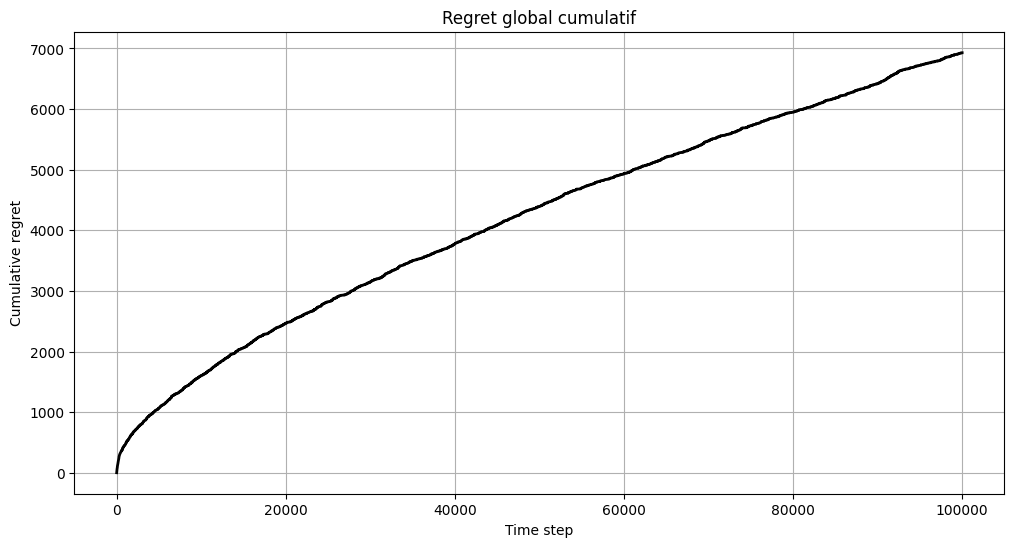

In [27]:
## Paramètres de simulation
N_STEPS = 100000

# Instanciation du recommender
recommender = EpsilonGreedyRecommender(
    df=synthetic_data,
    epsilon=1.0,
    decay_type='decay_optimal'
)

# Simulation
for t in range(N_STEPS):
    recommender.step() 

# Tracé du regret global cumulatif
plt.figure(figsize=(12,6))
plt.plot(recommender.regret_list, color='black', linewidth=2)
plt.xlabel("Time step")
plt.ylabel("Cumulative regret")
plt.title("Regret global cumulatif")
plt.grid(True)
plt.show()
